In [131]:
import numpy as np
import pandas as pd
from numpy.random import seed, randint
import urllib.request
import json
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# seed random number generator
seed(16)

# generate random integers
values = randint(0, 3047, 100)

# load the tweets dataset to pull out the 100 random tweets
tweets = pd.read_csv('tweets_with_sentiment.csv')
tweets.head()

,In reply to user name,Is quoted?,Is reply?,Like count,Location,Place,Retweet count,Source,User location,User name,User screen name,date,tweet,tweet_id,day,cleaned,label,tokenized_sents
0,NaN,1.0,NaN,7.0,NaN,NaN,0.0,Twitter Web Client,"Michigan, USA",STATE CHAMPS! RoboZone,RoboZoneShow,2018-06-28 16:18:13,Wonder how many @FRCTeams alumni will be worki...,1.012370e+18,2018-06-28 00:00:00,wonder how many alumni will be working at th...,1.0,"['wonder', 'many', 'alumni', 'working', 'propo..."
1,Ford,0.0,NaN,0.0,NaN,NaN,0.0,Twitter Web Client,"Detroit, MI",WXYZ Detroit,wxyzdetroit,2018-06-28 17:37:44,"@Ford has assembled a ""wish list"" of stolen #m...",1.012390e+18,2018-06-28 00:00:00,has assembled a wish list of stolen michi...,-1.0,"['assembled', 'wish', 'list', 'stolen', 'michi..."
2,NaN,0.0,NaN,2.0,NaN,NaN,2.0,Twitter Web Client,"Ann Arbor, MI",GMTA,GMTA_US,2018-06-27 19:35:52,#Ford will redevelop the #MichiganCentralStati...,1.012057e+18,2018-06-27 00:00:00,ford will redevelop the michigancentralstati...,1.0,"['ford', 'redevelop', 'michigancentralstation'..."
3,NaN,0.0,NaN,0.0,NaN,NaN,1.0,Twitter Web App,NaN,Izzyyyy🖤🤍💜,SilentxTime,2018-06-26 00:04:00,Whether it is a #detroitbecomehuman reference ...,1.011400e+18,2018-06-26 00:00:00,whether it is a detroitbecomehuman reference ...,-1.0,"['whether', 'detroitbecomehuman', 'reference',..."
4,NaN,0.0,NaN,4.0,NaN,NaN,0.0,Twitter Web Client,Internet,Rox-Anne Henderson,celebr8thislife,2018-06-25 19:07:30,Sharing a tour of the #michigancentralstation ...,1.011325e+18,2018-06-25 00:00:00,sharing a tour of the michigancentralstation ...,1.0,"['sharing', 'tour', 'michigancentralstation', ..."


In [112]:
# check for duplicate values
unique = set(values)
len(unique)

99

In [117]:
# pull out the tweets corresponding to the random integers
tweets_subset = tweets.iloc[values,:]
tweets_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 2729 to 421
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   In reply to user name  3 non-null      object 
 1   Is quoted?             100 non-null    float64
 2   Is reply?              2 non-null      float64
 3   Like count             100 non-null    float64
 4   Location               2 non-null      object 
 5   Place                  9 non-null      object 
 6   Retweet count          100 non-null    float64
 7   Source                 100 non-null    object 
 8   User location          85 non-null     object 
 9   User name              100 non-null    object 
 10  User screen name       100 non-null    object 
 11  date                   100 non-null    object 
 12  tweet                  100 non-null    object 
 13  tweet_id               100 non-null    float64
 14  day                    100 non-null    object 
 15  cle

In [45]:
# save subset to csv
tweets_subset.to_csv('tweets_subset.csv', index=False)

In [ ]:
# set Google credentials
%env GOOGLE_APPLICATION_CREDENTIALS= [##Path##]

In [41]:
def google_score(text):
    client = language.LanguageServiceClient()
    document = types\
               .Document(content=text,
                         type=enums.Document.Type.PLAIN_TEXT)
    sentiment_score = client\
                      .analyze_sentiment(document=document)\
                      .document_sentiment\
                      .score
    return sentiment_score

def get_qa_sentiments_google(text, label):
    min = -1
    max = 1
   
    questions = pd.DataFrame(columns=['text','goo_label'])

    for qfilter in text:

        a = google_score(qfilter)
        a = (a - min)/(max-min)
        a = round(a,2)
        if(a>0.5):
            b=1
        else:
            b=-1        

        questions['text'] = text
        questions['goo_label'] = b
           
    return(questions)


In [42]:
google_sent = get_qa_sentiments_google(tweets_subset['cleaned'],tweets_subset['label'])

In [43]:
google_sent.head()

,text,goo_label
2729,tbt to 2009 arguing in favor of demolition of...,1
2169,historic michigan central station sold to ford...,1
581,once a detroiter always a detroiter love the...,1
1345,ford announcing big plans to save detroit s mi...,1
635,nostalgic breathtaking views inside ford s f...,1


In [46]:
# save Google classifications
google_sent.to_csv('google_sent.csv', index=False)

In [10]:
def microsoft_score(text, sentimentUri, headers):
    # Determine sentiment
    postData2 = json.dumps({"documents":[{"id":"1", "text":text}]}).encode('utf-8')
    request2 = urllib.request.Request(sentimentUri, postData2, headers)
    response2 = urllib.request.urlopen(request2)
    response2json = json.loads(response2.read().decode('utf-8'))
    sentiment = response2json['documents'][0]['score'] # Sample json: {'errors': [], 'documents': [{'id': '1', 'score': 0.946106320818458}]}
    return(sentiment)
   
def get_qa_sentiments_microsoft(text, label):
    # set API access
    apiKey = '#########'
    sentimentUri = 'https://eastus.api.cognitive.microsoft.com/text/analytics/v2.0/sentiment'
    # Prepare headers
    headers = {}
    headers['Ocp-Apim-Subscription-Key'] = apiKey
    headers['Content-Type'] = 'application/json'
    headers['Accept'] = 'application/json'
   
    questions = pd.DataFrame(columns=['text','micro_label'])

    for qfilter in text:
        a = microsoft_score(qfilter, sentimentUri, headers)
        a = round(a,2)
        if(a>0.5):
            b=1
        else:
            b=-1
       
        questions['text'] = text
        questions['micro_label'] = b
        
           
    return(questions)

In [11]:
microsoft_sent = get_qa_sentiments_microsoft(tweets_subset['cleaned'],tweets_subset['label'])

In [14]:
microsoft_sent.head()

,text,micro_label
2729,tbt to 2009 arguing in favor of demolition of...,1
2169,historic michigan central station sold to ford...,1
581,once a detroiter always a detroiter love the...,1
1345,ford announcing big plans to save detroit s mi...,1
635,nostalgic breathtaking views inside ford s f...,1


In [16]:
# save microsoft classifications
microsoft_sent.to_csv('microsoft_sent.csv', index=False)

In [123]:
# add microsoft sentiment column to tweet subset
comparison = pd.merge(tweets_subset, microsoft_sent, left_on='cleaned', right_on='text')
comparison.drop_duplicates(inplace=True)
# add google sentiment column to tweet subset
comparison = pd.merge(comparison, google_sent, on='text')
comparison.drop_duplicates(inplace=True)
comparison.info()
# drop redundant text column
comparison.drop(columns=['text'],inplace=True)
comparison.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 0 to 103
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   In reply to user name  3 non-null      object 
 1   Is quoted?             99 non-null     float64
 2   Is reply?              2 non-null      float64
 3   Like count             99 non-null     float64
 4   Location               2 non-null      object 
 5   Place                  9 non-null      object 
 6   Retweet count          99 non-null     float64
 7   Source                 99 non-null     object 
 8   User location          84 non-null     object 
 9   User name              99 non-null     object 
 10  User screen name       99 non-null     object 
 11  date                   99 non-null     object 
 12  tweet                  99 non-null     object 
 13  tweet_id               99 non-null     float64
 14  day                    99 non-null     object 
 15  cleaned

,In reply to user name,Is quoted?,Is reply?,Like count,Location,Place,Retweet count,Source,User location,User name,User screen name,date,tweet,tweet_id,day,cleaned,label,tokenized_sents,micro_label,goo_label
0,NaN,1.0,NaN,6.0,NaN,NaN,2.0,Twitter for Android,Cuba of the North,"Nat M. Zorach, AICP, voting 🗳️",nzorach,2018-06-19 15:45:01,#tbt to 2009 arguing in favor of demolition of...,1.009100e+18,2018-06-19 00:00:00,tbt to 2009 arguing in favor of demolition of...,-1.0,"['tbt', '2009', 'arguing', 'favor', 'demolitio...",1,1
1,NaN,0.0,NaN,0.0,NaN,NaN,1.0,Twitter Web Client,"Windsor, Chatham-Kent, Leamington",Chris Campbell,CCampbellCTV,2018-06-11 14:34:09,Historic Michigan Central Station sold to Ford...,1.006183e+18,2018-06-11 00:00:00,historic michigan central station sold to ford...,-1.0,"['historic', 'michigan', 'central', 'station',...",1,1
2,NaN,0.0,NaN,1.0,NaN,NaN,0.0,Twitter Web Client,NaN,Matthew Hutchison,mhutchison,2018-06-25 21:21:40,"Once a Detroiter, always a Detroiter. Love the...",1.011359e+18,2018-06-25 00:00:00,once a detroiter always a detroiter love the...,1.0,"['detroiter', 'always', 'detroiter', 'love', '...",1,1
3,NaN,0.0,NaN,16.0,NaN,NaN,5.0,Twitter for Android,"Detroit, Michigan USA",WardsAuto,WardsAuto,2018-06-19 14:48:40,Ford announcing big plans to save Detroit's Mi...,1.009086e+18,2018-06-19 00:00:00,ford announcing big plans to save detroit s mi...,1.0,"['ford', 'announcing', 'big', 'plans', 'save',...",1,1
4,NaN,0.0,NaN,0.0,"{'type': 'Point', 'coordinates': [-83.07726862...",Place(_api=<tweepy.api.API object at 0x117d22a...,0.0,Instagram,@jpurifoyspeaks,J. Purifoy,DetBlkAttorney,2018-06-24 18:43:12,Nostalgic...breathtaking views inside Ford's f...,1.010957e+18,2018-06-24 00:00:00,nostalgic breathtaking views inside ford s f...,1.0,"['nostalgic', 'breathtaking', 'views', 'inside...",1,1


# Compare the sentiment classifications from Flair, Google, and Microsoft

In [130]:
# calculate how many classifiers agree 
comparison['agreement'] = comparison['label'] + comparison['micro_label'] + comparison['goo_label']

# check for different scenarios
comparison['agreement'].unique()

array([1., 3.])

<p style= "font-family: Times ; font-size: 18px">
Value meanings: <br>
3: all three classified this tweet as positive <br>
1: two classified this tweet as positive, one classified it as negative <br>
-1: two classified this tweet as negative, one classified it as positive <br>
-3: all three classified this tweet as negative <br>
<br>
The only values present in this dataset are 1 and 3

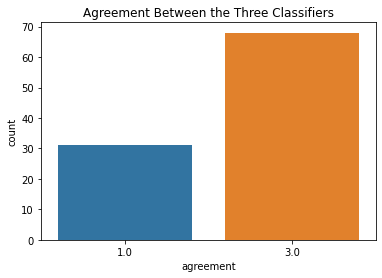

In [160]:
# plot counts of the agreement values
sns.countplot(x='agreement', data=comparison)
plt.title("Agreement Between the Three Classifiers");

In [142]:
#gains = df[df.buy_price < df.sell_price]
# count of agreement between flair and microsoft
f_m = comparison[comparison.label == comparison.micro_label]
print(len(f_m))
# count of agreement between flair and google
f_g = comparison[comparison.label == comparison.goo_label]
print(len(f_g))
# count of agreement between microsoft and google
m_g = comparison[comparison.micro_label == comparison.goo_label]
print(len(m_g))

68
68
99


<p style= "font-family: Times ; font-size: 18px">
Microsoft and Google classified the tweets exactly the same. 

In [146]:
# check if Google or Microsoft classified any tweet as negative
print(comparison['goo_label'].unique())
print(comparison['micro_label'].unique())

[1]
[1]


<p style= "font-family: Times ; font-size: 18px">
Neither Google nor Microsoft classifed any of these tweets as negative. Only Flair classified some of these tweets as negative. 

In [157]:
# pull out the tweets Flair classified as negative
flair_neg = comparison[comparison.label == -1]
pd.options.display.max_colwidth = 500
flair_neg['tweet']

0                    #tbt to 2009 arguing in favor of demolition of this structure: "Where ... is the demand for 500,000 square feet of highly blighted space in a building whose structural integrity is at least questionable?" #fordetroit\n\nhttps://t.co/MoJI3muduZ https://t.co/nQoZgpx3Q4
1                                                                                                                                                                                                           Historic Michigan Central Station sold to Ford Motor Company https://t.co/274HhmDCww
7       #ForDetroit In 2006 @DevinScillian asked a debate question of Granholm v Devos debate 2 question was from Macomb techie me on why stay in MI. @Ford train station may have just answered it 12 years later for younger future self :)\nhttps://t.co/yqzynHSLaC @phoebsaid @ChadLivengood
8                                                         @Ford files trademark on common Train Station names. Michigan Central Stati

<p style= "font-family: Times ; font-size: 18px">
Not every tweet Flair classified as negative is truly negative. For example: "a thief who stole a clock that hung on a gateway for decades at michigan central station in detroit reached out to anonymously return the antique timepiece" is not negative, although words like "stole" might cue Flair to classify it as such. <br><br>
However, Flair also catches some of the tweets that truly do seem negative, such as "So the beautiful Michigan Central Station building was sold to Ford? Not sure how I feel about this. It's like when Promedica bought the old Edison Steam Plant in Downtown Toledo. I'm glad it's getting a revival, but apprehensive about what is going to change...". Neither Google nor Microsoft classify this tweet as negative. <br><br>